In [1]:
from mmseg.datasets.viperSeq import ViperSeqDataset
from mmseg.datasets.viper import ViperDataset
from torch.utils.data import DataLoader
from functools import partial
from mmcv.parallel import collate
from mmseg.core.evaluation.metrics import flow_prop_iou, intersect_and_union
from tools.aggregate_flows.flow.my_utils import palette_to_id, backpropFlow, imageMap, imshow, labelMapToIm, visFlow
import torch
import numpy as np
from tqdm import tqdm

/srv/flash1/skareer6/miniconda3/envs/mmseg/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2022-11-07 11:52:53,339 - mmseg - INFO - Loaded 4959 images
2022-11-07 11:52:53,350 - mmseg - INFO - Loaded 4959 images
2022-11-07 11:52:53,361 - mmseg - INFO - Loaded 4959 images


PL:  {'im_load_pipeline': [{'type': 'LoadImageFromFile'}, {'type': 'LoadAnnotations'}], 'load_no_ann_pipeline': [{'type': 'LoadImageFromFile'}], 'load_flow_pipeline': [{'type': 'LoadFlowFromFile'}], 'shared_pipeline': [], 'im_pipeline': [{'type': 'DefaultFormatBundle'}, {'type': 'Collect', 'keys': ['img', 'gt_semantic_seg'], 'meta_keys': []}], 'flow_pipeline': [{'type': 'Pad', 'size': (720, 1280), 'pad_val': 0, 'seg_pad_val': 255}, {'type': 'DefaultFormatBundle'}, {'type': 'Collect', 'keys': ['img', 'gt_semantic_seg'], 'meta_keys': []}]}


  0%|                                                                                                                                                                                                                                                                                                                             | 0/4959 [00:00<?, ?it/s]

(1080, 1920, 3)
[540 960]


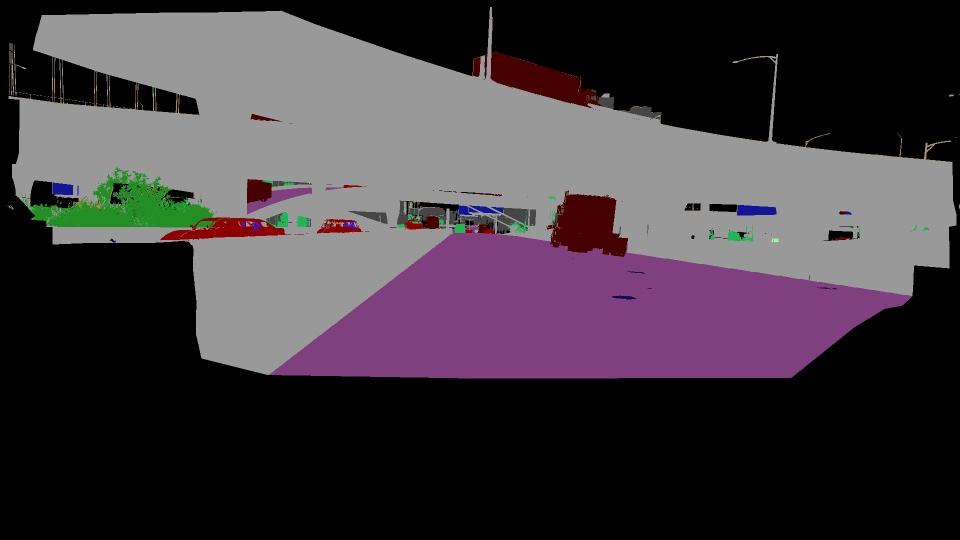

shape:  torch.Size([1080, 1920, 1]) masked:  tensor(960628)
before:  torch.Size([1080, 1920, 1]) torch.Size([1080, 1920, 1])
after:  torch.Size([960628]) torch.Size([960628])
----------------------------------------------------------------------------------------------------
unlabeled      : 0.00
sky            : 20.04
road           : 96.62
terrain        : 10.27
tree           : 15.91
vegetation     : 58.13
building       : 35.08
infrastructure : 93.66
billboard      : 44.26
trash          : 0.00
person         : 0.00
car            : 33.52
truck          : 75.79
trailer        : 6.32
mean           : 34.97
(1080, 1920, 3)
[540 960]


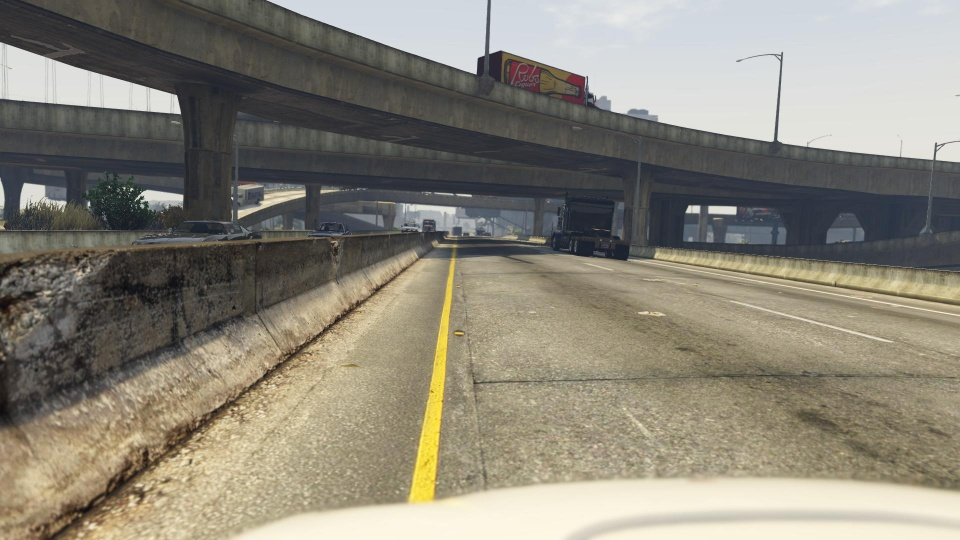

(1080, 1920, 3)
[540 960]


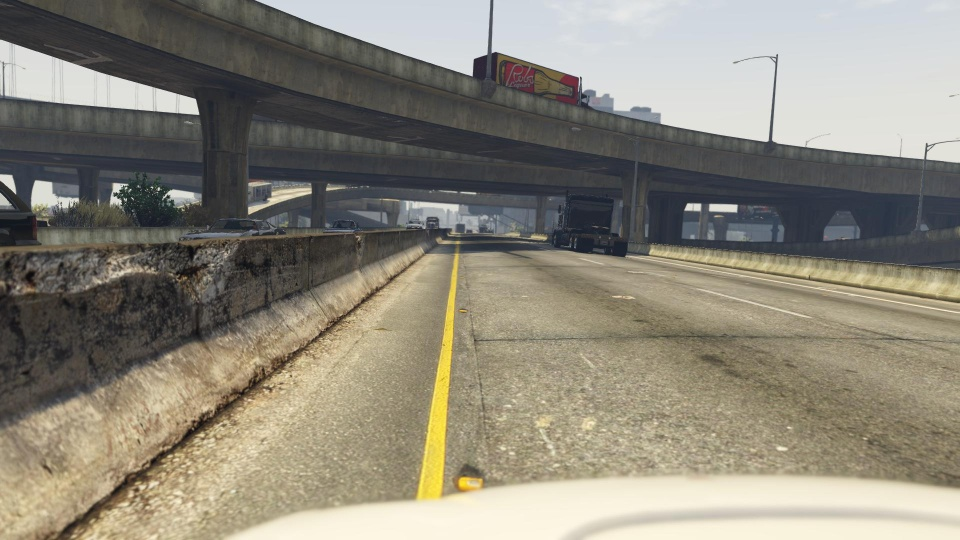

(1080, 1920, 3)
[540 960]


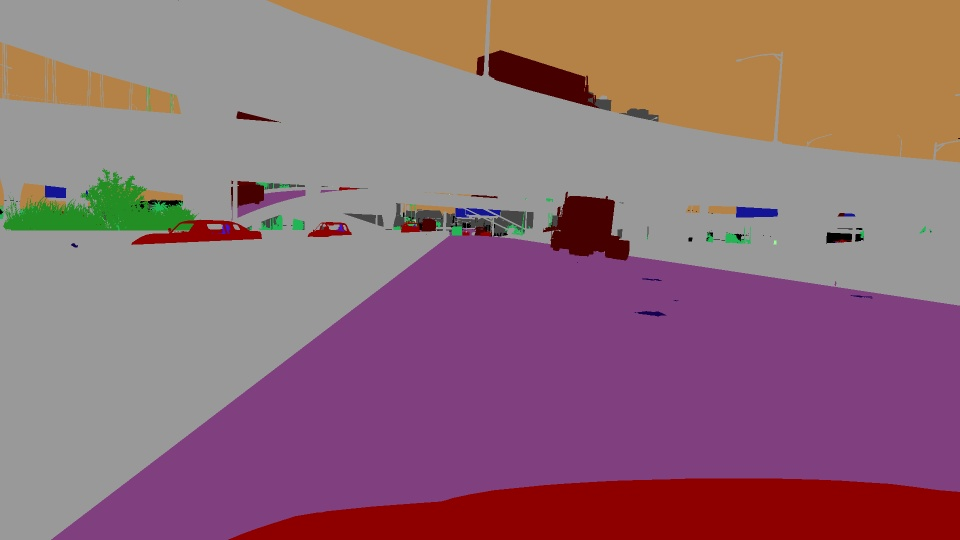

(1080, 1920, 3)
[540 960]


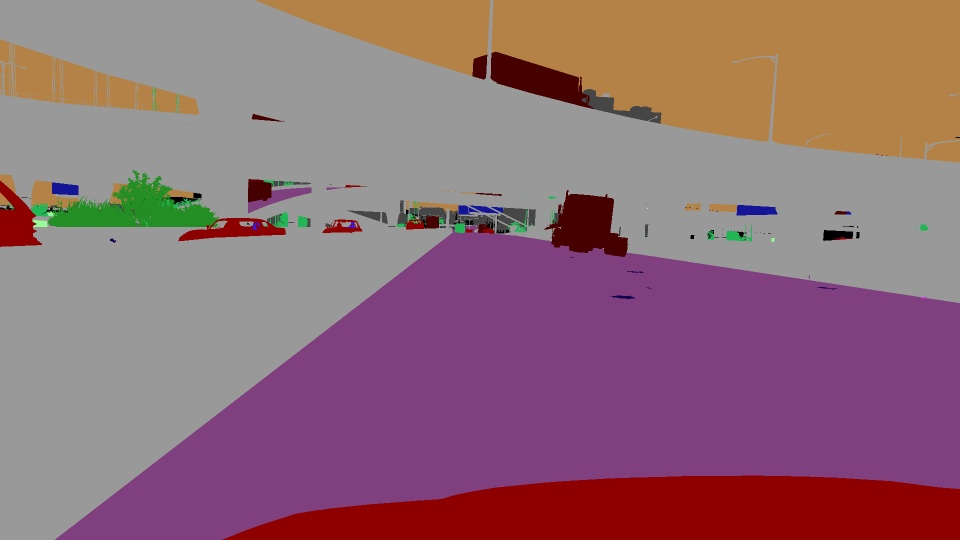

(1080, 1920, 3)
[540 960]


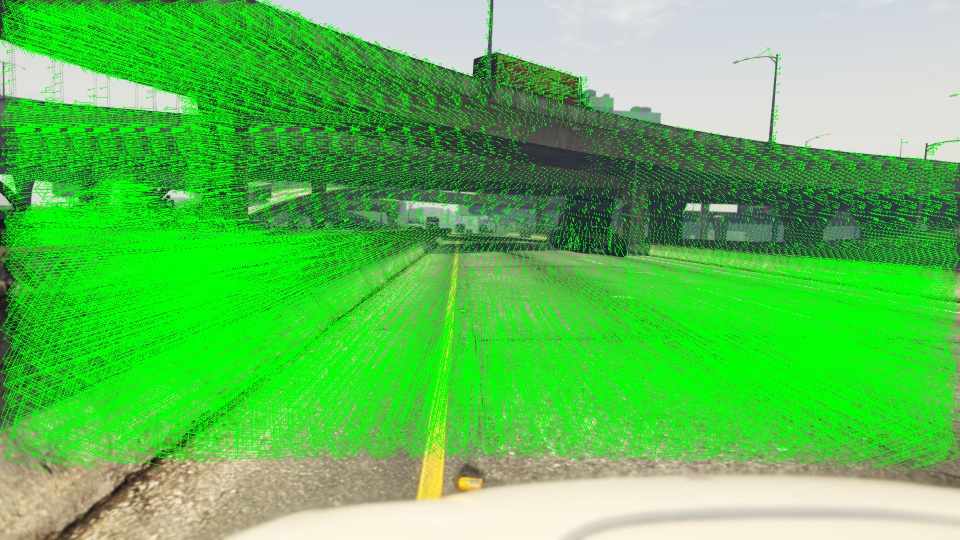

  0%|                                                                                                                                                                                                                                                                                                                             | 0/4959 [00:04<?, ?it/s]


In [2]:
CLASSES = ("unlabeled", "ambiguous", "sky","road","sidewalk","railtrack","terrain","tree","vegetation","building","infrastructure","fence","billboard","trafficlight","trafficsign","mobilebarrier","firehydrant","chair","trash","trashcan","person","animal","bicycle","motorcycle","car","van","bus","truck","trailer","train","plane","boat")

def formatmIoU(miou, names, print_na=False):
    cml_sum = 0
    count = 0
    for val, name in zip(miou, names):
        val=val.item()
        if not np.isnan(val) or print_na:
            print(f"{name:15s}: {val*100:2.2f}")
        if not np.isnan(val):
            cml_sum += val
            count += 1
    
    # print("HI: ", cml_sum)
    print(f"{'mean':15s}: {cml_sum*100/count:2.2f}")


def main():
    # dataset settings
    dataset_type = 'ViperDataset'
    data_root = '/srv/share4/datasets/VIPER/'

    #imagenet values
    img_norm_cfg = dict(
        mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)

    #crop size from the da-vsn paper code
    crop_size = (720, 1280)

    train_pipeline = {
        "im_load_pipeline": [
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations'),
        ],
        "load_no_ann_pipeline": [
            dict(type='LoadImageFromFile'),
        ],
        "load_flow_pipeline": [
            dict(type='LoadFlowFromFile'),
        ],
        "shared_pipeline": [
            # dict(type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),
            # dict(type='RandomCrop', crop_size=crop_size, cat_max_ratio=0.75),
            # dict(type='RandomFlip', prob=0.5),
        ],
        "im_pipeline": [
            # dict(type='PhotoMetricDistortion'),
            # dict(type='Normalize', **img_norm_cfg),
            # dict(type='Pad', size=crop_size, pad_val=0, seg_pad_val=255),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_semantic_seg'], meta_keys=[]),
        ],
        "flow_pipeline": [
            dict(type='Pad', size=crop_size, pad_val=0, seg_pad_val=255),
            dict(type='DefaultFormatBundle'), #I don't know what this is
            dict(type='Collect', keys=['img', 'gt_semantic_seg'], meta_keys=[]),
        ]
    }

    img_dir = '/srv/share4/datasets/VIPER/'

    viper = ViperSeqDataset(
        # type=dataset_type,
        split='splits/val.txt',
        frame_offset=1,
        flow_dir="/srv/share4/datasets/VIPER_Flowv3/val/flow_occ",
        data_root=data_root,
        img_dir='val/img',
        ann_dir='val/cls',
        pipeline=train_pipeline
    )

    # data_loader = DataLoader(viper)
    data_loader = DataLoader(
        viper,
        collate_fn=partial(collate, samples_per_gpu=1)
    )

    cml_intersect = torch.zeros(31)
    cml_union = torch.zeros(31)
    for i, data in enumerate(tqdm(data_loader)):
        # print(data)
        im, imtk, flow, gt_t, gt_tk = data["img"].data[0], data["imtk"].data[0], data["flow"].data[0], data["gt_semantic_seg"].data[0], data["imtk_gt_semantic_seg"].data[0]
        # print("im: ",im.shape, imtk.shape, flow.shape, gt_t.shape, gt_tk.shape)
        flow = flow.squeeze(0).permute((1, 2, 0))
        gt_t = gt_t.squeeze(0).permute((1, 2, 0))
        gt_tk = gt_tk.squeeze(0).permute((1, 2, 0))
        im = im.squeeze(0).permute((1, 2, 0))
        imtk = imtk.squeeze(0).permute((1, 2, 0))
        
        intersect, union = flow_prop_iou(gt_t, gt_tk, flow)
        assert(intersect.shape == (31,) and union.shape==(31,))
        cml_intersect += intersect
        cml_union += union

        if i % 10 == 0:
            print("-"*100)
            formatmIoU(cml_intersect/cml_union, CLASSES)
        
        # Viz
        mapped_gt_t = imageMap(gt_t.numpy(), palette_to_id)
        mapped_gt_tk = imageMap(gt_tk.numpy(), palette_to_id)
        imshow(im.numpy(), scale=0.5)
        imshow(imtk.numpy(), scale=0.5)
        gt_t = labelMapToIm(gt_t.long(), palette_to_id)
        gt_tk = labelMapToIm(gt_tk.long(), palette_to_id)
        imshow(gt_t.numpy().astype(np.int16), scale=0.5)
        imshow(gt_tk.numpy().astype(np.int16), scale=0.5)
        imshow(visFlow(flow.numpy(), image=imtk.numpy(), skip_amount=50), scale=0.5)
            
            
            
        break

main()